# TSFS12: Simple startup use-case in Carla -- plan a mission and implement a state-feedback path follower

The simulator CARLA is open-source and can be downloaded and run on Linux and Windows. It does require a decent GPU card and computational power. In the computer labs, only computers in room Olympen are powerful enough.

## Configure Python environment 

The current version of the Carla Python API works best with Python version 3.5, so make sure you run the correct version. If you activate the pre-prepared virtual environment, you get the correct python version and all packages needed to get up and running. To activate the environment run the folloowing command in the terminal:
```
source /courses/tsfs12/carla_env/bin/activate
```

Finally, to run the code in this notebook you need to make sure Carla specific Python modules are in the module path. You can set the environment variable ```PYTHONPATH``` as
```
export PYTHONPATH=/courses/tsfs12/CARLA/PythonAPI/carla/dist/carla-0.9.6-py3.5-linux-x86_64.egg:/courses/tsfs12/CARLA/PythonAPI/carla
```
and then you can start JupyterLab as normal
```
jupyter lab
```

For convencience, you may add corresponding line in your ```.bashrc``` file so you do not have to ensure paths every time.

I have distributed this information in Jupyter Notebooks but you may want to implement your solutions in regular python scripts. I have implemented the code in this notebook as a script ```path_following.py``` and you run it from the terminal with the command
```
python path_following.py
```

## How to find information

You will need to read carla documentation, available at the carla homepage https://http://carla.org/. Start
 with the documentation at https://carla.readthedocs.io/ and I strongly recommend looking through the tutorials at https://carla.readthedocs.io/en/latest/python_api_tutorial/. When developing, you will use the Python API reference https://carla.readthedocs.io/en/latest/python_api/. I also strongly recommend to look through the examples in the Carla distribution that can be found in ```/courses/tsfs12/CARLA/PythonAPI/examples```.

## Initial imports

In [1]:
import carla
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from agents.navigation.global_route_planner_dao import GlobalRoutePlannerDAO
from agents.navigation.global_route_planner import GlobalRoutePlanner
from algs import splinepath
from agents.navigation.local_planner import RoadOption

In [2]:
rg = np.random.default_rng()

## Connect to a running Carla server and get main pointers

Get pointer to Carla and load a world

In [3]:
HOST = 'localhost'
PORT = 2000
client = carla.Client(HOST, PORT)
client.set_timeout(2.0)

In [4]:
client.load_world('Town03')  # Town01-Town07 are available

RuntimeError: failed to connect to newly created map

Get pointers to the world and blueprint library (templates to all actors and vehicles).

In [5]:
world = client.get_world()
bpl = world.get_blueprint_library()
sp = world.get_spectator()  # Get pointer to the spectator, i.e., camera in the server window

It is easy to manipulate the world, e.g., change the wather.

In [6]:
weather = world.get_weather()
world.set_weather(weather.ClearNoon)

Get information about the spectator, e.g., position and orientation. Experiment by moving around in the world and see how things change.

In [7]:
print(sp.get_transform())

Transform(Location(x=44.070000, y=-5.840000, z=4.150000), Rotation(pitch=0.000000, yaw=173.198349, roll=0.000000))


## A simple first test-case -- path following in an empty world

### Spawn a car in the world

This is an example planning mission (defined for Town03). Positions specified using the carla ```Location``` type.

In [8]:
p1 = carla.Location(x=200, y=-6, z=1)  # Start point
p2 = carla.Location(x=142.1, y=64, z=1)  # End point

Find a random type of Audi in the library of available vehicles.

In [9]:
print('Available Audis')
for c in bpl.filter('vehicle.audi.*'):
    print(c.id)
bp = rg.choice(bpl.filter('vehicle.audi.*'))
print('Random selection: {}'.format(bp.id))

Available Audis
vehicle.audi.a2
vehicle.audi.etron
vehicle.audi.tt
Random selection: vehicle.audi.a2


Spawn the car at the start point. Go and look for it in the world. It is also a good idea to keep track of created actors in the world so that you can clean up at the end.

In [10]:
actors = []
car = world.spawn_actor(bp, carla.Transform(p1))
actors.append(car)

### Plan a mission

Make a plan using the carla provided A* planner (you are welcome to integrate your planner from hand-in 1 if you like but you do not have to). Also create a ```SplinePath ``` object of the resulting plan.

In [11]:
RADIUS = 5
map = world.get_map()
dao = GlobalRoutePlannerDAO(map, sampling_resolution=RADIUS)
rp = GlobalRoutePlanner(dao)
rp.setup()
route = rp.trace_route(p1, p2)

## Create path object using nodes
p = np.array([(ri[0].transform.location.x, ri[0].transform.location.y)
              for ri in route])
path = splinepath.SplinePath(p, min_grid=3)
print('Length of planned path: {:.2f} m'.format(path.length))

Length of planned path: 825.16 m


Move car and spectator to beginning of plan.

In [12]:
t = route[0][0].transform
car.set_transform(t)
t.location.z += 15  # 15 meters above car
sp.set_transform(t)

# Add a car(obstacle) on the calculated path

In [13]:
car_obs = world.spawn_actor(bp, carla.Transform(route[5][0].transform.location))
actors.append(car_obs)

Plot the resulting plan in matplotlib

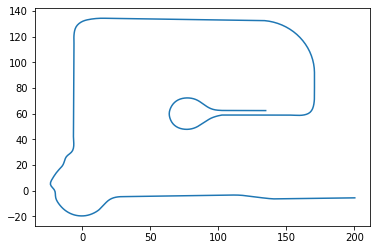

In [303]:
s = np.linspace(0, path.length, 500)
plt.figure(10, clear=True)
_ = plt.plot(path.x(s), path.y(s))

Plot the plan in the Carla simulator.

In [304]:
T = 10  # Time before line dissapears, negative for never
for s1, s2 in zip(s[:-1], s[1:]):
    s1_loc = carla.Location(x=float(path.x(s1)), y=float(path.y(s1)), z=0.5)
    s2_loc = carla.Location(x=float(path.x(s2)), y=float(path.y(s2)), z=0.5)
    world.debug.draw_line(s1_loc, s2_loc, thickness=0.35, 
                          life_time=T, color=carla.Color(b=255))

### Implement a simple path following controller similar to hand-in 3

Using a simple state-feedback controller as a path follower. Using similar structure as in hand-in 3.

In [305]:

class StateFeedbackController:
    def __init__(self, K, L, path=None, goal_tol=1):
        self.plan = path
        self.K = K
        self.goal_tol = goal_tol
        self.d = []
        self.delta = []
        self.theta_e = []
        self.s_p = []
        self.L = L
        self.s0 = 0

        self.t = []
        self.w = []

    def heading_error(self, heading, s):
        """Compute theta error"""
        heading0, nc = self.plan.heading(s)
        cos_alpha = heading.dot(heading0)
        sin_alpha = np.float(np.cross(heading0, heading))

        theta_e = np.arctan2(sin_alpha, cos_alpha)
        return theta_e

    def u(self, t, w):
        def glob_stab_fact(x):
            """Series expansion of sin(x)/x around x=0."""
            return 1 - x**2/6 + x**4/120 - x**6/5040

        a = 0
        x, y, theta, v = w
        self.w.append(w)
        p_car = w[0:2]
        si, d = self.plan.project(p_car, self.s0, ds=2, s_lim=20)
        self.s0 = si

        heading = np.array([np.cos(theta), np.sin(theta)])
        theta_e = self.heading_error(heading, si)

        # No feed-forward term
        u =  - self.K.dot(np.array([d*glob_stab_fact(theta_e), theta_e]))[0]
        delta = np.max((-1.0, np.min((1.0, self.L*u))))
        
        self.d.append(d)
        self.delta.append(delta)
        self.s_p.append(si)
        self.theta_e.append(theta_e)
        self.t.append(t)

        return np.array([delta, a])
    
    def run(self, t, w):
        p_goal = self.plan.path[-1, :]
        p_car = w[0:2]
        dp = p_car - p_goal
        dist = np.sqrt(dp.dot(dp))
        if dist < self.goal_tol:
            return False
        else:
            return True

In [314]:
def calculate_path():
    
    def _is_equal(wp1, wp2, offset=0.2)
        
            
            
        
    #car_wp = map.get_waypoint(car.get_location(),project_to_road=True, lane_type=(carla.LaneType.Driving))
    
    obstacles = [] #Waypoints of all obstacles, should be exchanged with waypoint generated by RPLidar
    for i in range(1, len(actors)):
        obstacles.append(map.get_waypoint(actors[i]))
     
    lanes = ["right", "left", "same"]
    score = [0,0,0]
        
    for i in range(len(lanes)):
        lane = lanes[i]
        if lane == "same":
            wp = car[0]
        elif lane == "right":
            wp = car[0].get_left_lane()
        else:
            wp = car[0].get_right_lane()
            
        found_obstacle = False
        while True:
            if wp.is_junction or wp == None:
                score[i] = 0
                break
            for obstacle in obstacles:
                if is_equal(wp.transform.location, obstacle.transform.location):
                    score[i] = get_distance_diff(wp.transform.location, obstacle.transform.location) + get_velocity_diff(wp.get_velocity, obstacle.get_velocity)
                    found_obstacle = True
                    break
            if found_obstacle:
                break
            else:
                wp = wp.next(RADIUS)[0]
    
    available_lanes = car[0].lane_change
    

    new_lane = "same"
    both = carla.LaneChange.Both
    left = carla.LaneChange.Left
    
    if lane_change == left or lane_change == both  :
        new_lane = "same"
    
                
    
                
                
                    
                 
                       
                       
                       
                       
                       
    #Check if there is cars in the same lane with a radius of five waypoints
    car_wp = car_wp.next(RADIUS)[0]
    
    
        for obs_loc in obs_wps:
            car_location = car_wp.transform.location
            if abs(car_location.x - obs_loc.x) < 0.2 and abs(car_location.y - obs_loc.y) < 0.2: 
                change_lane = True
                i = 5
                break
        wp = wp[0].next(RADIUS)
        i = i+1
        
    print(change_lane)
    
    if(change_lane):
        index = -1
        #Get wp index in route
        for i in range(0, len(route)):
            loc = route[i][0].transform.location
            wp_loc = wp[0].transform.location
            if( abs(wp_loc.x - loc.x) < 0.2 and abs(wp_loc.y - loc.y) < 0.2):
                index = i
                break
        print("index is ", index)
        print("lane change is ", route[index][0].lane_change)
        print("type is ", type(route[index][0].lane_change))
        if index != -1 and route[index][0].lane_change == carla.LaneChange.Left:
            print("changing lane")
            route[i] = (route[i][0], RoadOption.CHANGELANELEFT)
    
    
        
    
        


### Setup world for simulation

In [315]:
# settings = world.get_settings()
# settings.fixed_delta_seconds = None # 0.05  # 20 Hz
# settings.synchronous_mode = False
# _ = world.apply_settings(settings)

Locate the car in the beginning of the plan and set speed to 0.

In [316]:
init_transform = route[0][0].transform # Set car in initial position of the plan
car.set_transform(init_transform)
car.apply_control(carla.VehicleControl(throttle=0, steer=0))

Run the path follower

In [ ]:
K = np.array([0.1, 0.25]).reshape((1, 2))
L = 3.5
ctrl = StateFeedbackController(K, L, path)
car_states = []
tl = []
while ctrl.s0 < path.length-5:
    tck = world.wait_for_tick(1)
    t = car.get_transform()
    v = car.get_velocity()
    v = np.sqrt(v.x**2+v.y**2+v.z**2)
    w = np.array([t.location.x, t.location.y, t.rotation.yaw*np.pi/180.0, v])
    car_states.append(w)

    # Compute control signal and apply to car
    u = ctrl.u(tck.timestamp.elapsed_seconds, w)
    car.apply_control(carla.VehicleControl(throttle=0.7, steer=u[0]))
    calculate_path()

# Stop car after finished route    
car.apply_control(carla.VehicleControl(throttle=0, steer=0))
car_states = np.array(car_states)
ctrl.t = np.array(ctrl.t)-ctrl.t[0]

print('Mean Ts = {:.1f} msek. std-dev = {:.1f} msek'.format(
    np.mean(np.diff(ctrl.t))*1000, np.std(np.diff(ctrl.t))*1000))

### Plot some results

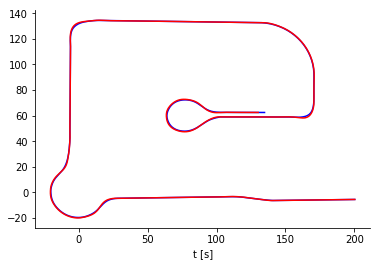

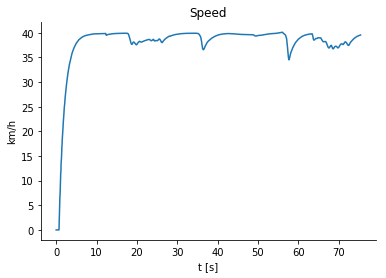

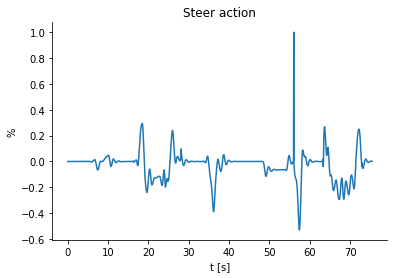

In [22]:
s = np.linspace(0, path.length, 500)
plt.figure(20, clear=True)
plt.plot(path.x(s), path.y(s), 'b', label='Planned path')
plt.plot(car_states[:, 0], car_states[:, 1], 'r', label='Actual path')
plt.xlabel('t [s]')
sns.despine()

plt.figure(21, clear=True)
plt.plot(ctrl.t, car_states[:, 3]*3.6)
plt.ylabel('km/h')
plt.title('Speed')
plt.xlabel('t [s]')
sns.despine()

plt.figure(22, clear=True)
plt.plot(ctrl.t, ctrl.delta)
plt.ylabel('%')
plt.title('Steer action')
plt.xlabel('t [s]')
sns.despine()

## Cleanup

If you have kept pointers to all created actors, cleanup is simple

In [15]:
for a in actors:
    a.destroy()
actors = []